<a href="https://www.kaggle.com/code/leekahwin/forecast-and-visualization-of-total-sales?scriptVersionId=102979953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In today's competitive world, where sales are extremely important for every business, accurate sales forecasting is critical to every successful business. As a matter of fact, cinema business is not exempt from benefiting from the predictive modelling. Without sales forecasting, industry like cinema is likely to be more uncertain in allocating resources for future growth and manage their cash flow. 

In this notebook, both time series and machine learning modelling techniques will be used to implement the sales forecasting of the dataset.

# Contents
* [Import Libraries and Functions](#0.1)
* [Pre-processing](#0.2)
* [Univariate Analysis](#0.3)
* [Descriptive Time Series](#0.4)
* [Plot a Time Series](#0.5)
* [Check Original Stationarity](#0.6)
* [Differencing](#0.7)
* [Autocorrelation and Partial Autocorrelation](#0.8)
* [Find Best ARIMA](#0.9)
* [ARIMA Result](#0.10)
* [Residual Plot](#0.11)
* [Prediction Plot](#0.12)
* [SARIMAX](#0.13)
* [Machine Learning](#0.14)
* [Concluding Remarks for Model Selection](#0.15)

# Import Libraries and Functions <a class="anchor" id="0.1"></a>

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.style
import warnings
from IPython.display import display
from matplotlib.pyplot import figure
matplotlib.style.use('fivethirtyeight')
fig = matplotlib.pyplot.gcf()
import statsmodels.api as sm
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

!pip install pmdarima
from pmdarima import auto_arima
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from calendar import day_name
from statsmodels.tsa.stattools import adfuller
import warnings


def null(df,df_name):
    if df.isnull().values.any() ==False:
        print(f'STATUS: There is NO ANY null value in {df_name}')
    else:
        print('STATUS: There is null value in dataframe')
        columns = df.columns[df.isna().any()].tolist()
        temp = {}
        for column in columns:
            count = (len(df)) - (df[column].count())
            temp[column] = f"{count} ({round((count/len(df)), 4)*100}%)"
        print(f'STATUS: Nulls of {df_name} = {temp} of total {len(df)}')

def duplicate(df, column):
    if len(df[df[column].duplicated()]) ==0:
        print(f'STATUS: There is NO ANY duplicate value in the column of "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column of "{column}"')

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    print(f'STATUS: Value counts of "{column}"...')
    display(vc_df)
    if r:
        return vc_df

def pie(df, column):
    (df[column].value_counts().plot(kind='pie' , autopct='%1.1f%%', title=f'Pie chart of "{column}"'))
    return plt.show()

def drop(df, column):
    df2 = df.drop(column, axis=1)
    print(f"STATUS: Columns of {column} were dropped")
    return df2

def dtype(df, column):
    print(f"STATUS: Data type of {column} = {df[column].dtypes}")

def unique(df, column, r =False):
    num = len(df[column].unique())
    print(f"STATUS: Unique value for {column} = {num}")
    if r:
        return num

def move_front(df, column):
    df = df[ [column] + [ col for col in df.columns if col != column ] ]
    return df

pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'

# read dataset
df = pd.read_csv('../input/cinema-ticket/cinemaTicket_Ref.csv')

# set as type datetime
df['date'] = pd.to_datetime(df["date"],errors='coerce')
n_unique_film = df['film_code'].nunique()
n_unique_cinema = df['cinema_code'].nunique()
print(f"number of unique films = {n_unique_film}")
print(f"number of unique cinemas = {n_unique_cinema}")
shape(df,'df')
number_duplicates = len(df[df.duplicated()])
number_duplicates
print(f"STATUS: total duplicated rows = {number_duplicates}")

df.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.4 MB/s eta 0:00:00
number of unique films = 48
number of unique cinemas = 246
STATUS: Dimension of "df" = (142524, 14)
STATUS: total duplicated rows = 106


,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,occu_perc,ticket_price,ticket_use,capacity,date,month,quarter,day
0,1492,304,3900000,26,0,4,4.26,150000.0,26,610.328638,2018-05-05,5,2,5
1,1492,352,3360000,42,0,5,8.08,80000.0,42,519.801980,2018-05-05,5,2,5
2,1492,489,2560000,32,0,4,20.00,80000.0,32,160.000000,2018-05-05,5,2,5
3,1492,429,1200000,12,0,1,11.01,100000.0,12,108.991826,2018-05-05,5,2,5
4,1492,524,1200000,15,0,3,16.67,80000.0,15,89.982004,2018-05-05,5,2,5


<Figure size 432x288 with 0 Axes>

# Preprocessing <a class="anchor" id="0.2"></a>

In [2]:
# drop all duplicated rows
df2 = df.drop_duplicates()
print("STATUS: Dropped duplicates")
null(df2,'df2')

# drop columns with null values
df2 = drop(df2, ['occu_perc', 'capacity','month','quarter','day'])
shape(df2,'df2')

# There is still a duplicated dimension columns
duplicate(df2,'film_code')
duplicate(df2,'cinema_code')

# Solution: Concatenate dimensions to create unique id
cols = ['film_code', 'cinema_code','date']
df2['id'] = df2[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df2 = move_front(df2, 'id')

# Now each row representing a particular date showing a particular film at a particular cinema 
duplicate(df2,'id')
display(df2.head())

# Value counts
vc(df2, 'tickets_out')
vc(df2, 'film_code')
df2.info()

STATUS: Dropped duplicates
STATUS: There is null value in dataframe
STATUS: Nulls of df2 = {'occu_perc': '123 (0.09%)', 'capacity': '123 (0.09%)'} of total 142418
STATUS: Columns of ['occu_perc', 'capacity', 'month', 'quarter', 'day'] were dropped
STATUS: Dimension of "df2" = (142418, 9)
STATUS: There are 142370 duplicate values in the column of "film_code"
STATUS: There are 142172 duplicate values in the column of "cinema_code"
STATUS: There is NO ANY duplicate value in the column of "id"


,id,film_code,cinema_code,total_sales,tickets_sold,tickets_out,show_time,ticket_price,ticket_use,date
0,1492_304_2018-05-05 00:00:00,1492,304,3900000,26,0,4,150000.0,26,2018-05-05
1,1492_352_2018-05-05 00:00:00,1492,352,3360000,42,0,5,80000.0,42,2018-05-05
2,1492_489_2018-05-05 00:00:00,1492,489,2560000,32,0,4,80000.0,32,2018-05-05
3,1492_429_2018-05-05 00:00:00,1492,429,1200000,12,0,1,100000.0,12,2018-05-05
4,1492_524_2018-05-05 00:00:00,1492,524,1200000,15,0,3,80000.0,15,2018-05-05


STATUS: Value counts of "tickets_out"...


,count,percentage (%)
tickets_out,,
0,136297,95.702088
2,1613,1.132582
1,1491,1.046918
3,761,0.534343
4,604,0.424104
...,...,...
86,1,0.000702
87,1,0.000702
91,1,0.000702


STATUS: Value counts of "film_code"...


,count,percentage (%)
film_code,,
1554,11614,8.154868
1493,10491,7.366344
1481,9531,6.692272
1484,8551,6.004157
1482,7397,5.193866
1556,7000,4.915109
1483,6972,4.895449
1485,6096,4.280358
1494,6022,4.228398


<class 'pandas.core.frame.DataFrame'>
Int64Index: 142418 entries, 0 to 142523
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            142418 non-null  object        
 1   film_code     142418 non-null  int64         
 2   cinema_code   142418 non-null  int64         
 3   total_sales   142418 non-null  int64         
 4   tickets_sold  142418 non-null  int64         
 5   tickets_out   142418 non-null  int64         
 6   show_time     142418 non-null  int64         
 7   ticket_price  142418 non-null  float64       
 8   ticket_use    142418 non-null  int64         
 9   date          142418 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 12.0+ MB


In [3]:
n_unique_film = df2['film_code'].nunique()
n_unique_cinema = df2['cinema_code'].nunique()
print(f"number of unique films = {n_unique_film}")
print(f"number of unique cinemas = {n_unique_cinema}")

number of unique films = 48
number of unique cinemas = 246


# Univariate Analysis <a class="anchor" id="0.3"></a>

The target variable in this paper is total sales. The target variable is having right-skewed where there are quite a number of extreme values. To explain, the maximum values is near to 12 times larger than the first bin (i.e., from 0 to 100,000,000) of the maximum values, where the first bin accounted 98% of the data. Hence, those values are considered truly aberrant and it will affect the model badly if these uncommon extreme values are taken into account.

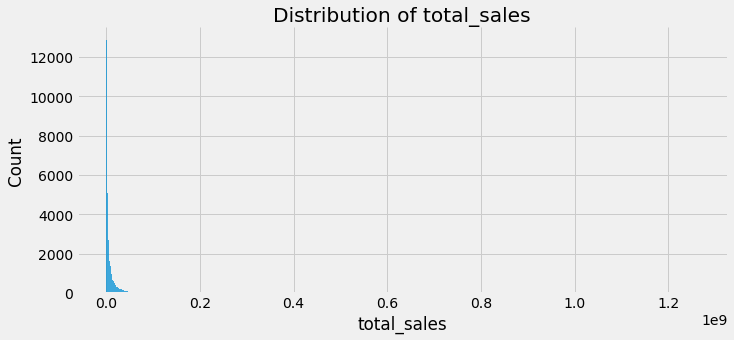

In [4]:
def vis_dist(df, col, lim=False):
    variable = df[col].values
    ax = sns.displot(variable)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, 4000)
    return plt.show()
vis_dist(df2, 'total_sales', lim=False)

STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0, 100000000]",139884,98.221420
"(100000000, 200000000]",1931,1.355877
"(200000000, 300000000]",350,0.245757
"(300000000, 400000000]",126,0.088473
"(400000000, 500000000]",57,0.040023
"(600000000, 700000000]",29,0.020363
"(500000000, 600000000]",28,0.019661
"(700000000, 800000000]",4,0.002809
"(800000000, 900000000]",3,0.002106


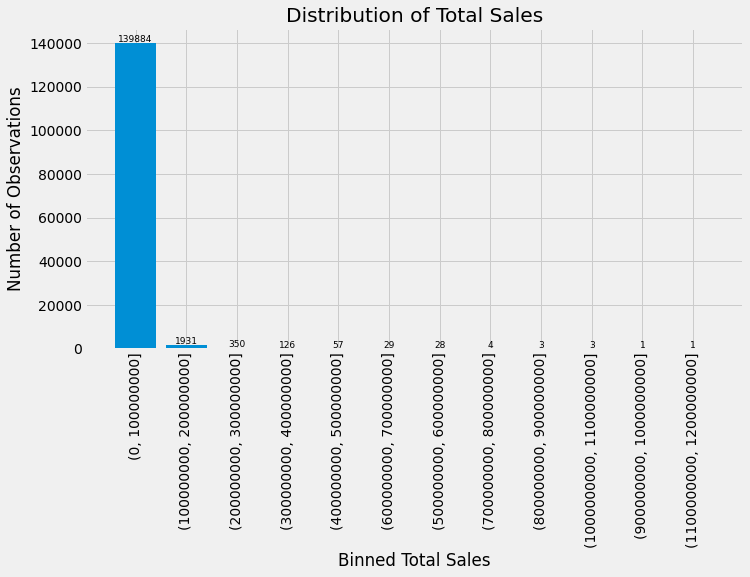

In [5]:
df_uni = df2.copy()
bins = np.arange(0, 1300000000, 100000000)
df_uni['binned'] = pd.cut(df2['total_sales'], bins)
v_count = vc(df_uni, 'binned', r=True)
v_count = v_count.reset_index()
v_count['binned'] = v_count['binned'].astype("str")
x_value =v_count['binned'].values
y_value =v_count['count'].values
plt.bar(x_value, y_value)
plt.ylabel('Number of Observations')
plt.xlabel('Binned Total Sales')
plt.title(f'Distribution of Total Sales')
plt.xticks(rotation=90)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
for x,y in zip(x_value,y_value):
    label = "{:.1%}".format(y)
    plt.annotate(int(y), # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1), # distance from text to points (x,y)
                 ha='center' , fontsize=9) # horizontal alignment can be left, right or center
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 5.5)
plt.show()

In [6]:
# IQR

# Select the first quantile
q1 = df2['total_sales'].quantile(.25)
print(f"q1 = {q1}")
# Select the third quantile
q3 = df2['total_sales'].quantile(.75)
print(f"q3 = {q3}")
iqr = q3-q1
print(f"iqr = {iqr}")
S = 1.5*iqr
print(f"S = {S}")
UB = q3 + S 
LB = q1 - S 
print(f"valid range : {LB} <= total sales <= {UB}")

df_uni = df2.copy()
bins = np.arange(0, 1300000000, UB)
df_uni['binned'] = pd.cut(df2['total_sales'], bins)
v_count = vc(df_uni, 'binned', r=True)
display(v_count)

q1 = 1260000.0
q3 = 11100000.0
iqr = 9840000.0
S = 14760000.0
valid range : -13500000.0 <= total sales <= 25860000.0
STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0.0, 25860000.0]",126416,88.764061
"(25860000.0, 51720000.0]",9192,6.454240
"(51720000.0, 77580000.0]",3010,2.113497
"(77580000.0, 103440000.0]",1415,0.993554
"(103440000.0, 129300000.0]",850,0.596835
"(129300000.0, 155160000.0]",514,0.360909
"(155160000.0, 181020000.0]",282,0.198009
"(181020000.0, 206880000.0]",190,0.133410
"(206880000.0, 232740000.0]",124,0.087068


,count,percentage (%)
binned,,
"(0.0, 25860000.0]",126416,88.764061
"(25860000.0, 51720000.0]",9192,6.454240
"(51720000.0, 77580000.0]",3010,2.113497
"(77580000.0, 103440000.0]",1415,0.993554
"(103440000.0, 129300000.0]",850,0.596835
"(129300000.0, 155160000.0]",514,0.360909
"(155160000.0, 181020000.0]",282,0.198009
"(181020000.0, 206880000.0]",190,0.133410
"(206880000.0, 232740000.0]",124,0.087068


In [7]:
# EMPIRICAL RULE

mean = df2['total_sales'].mean() ; print(f"mean = {mean}")
std = df2['total_sales'].std() ; print(f"std = {std}")
if std>mean:
    print(f"standard deviation is {std/mean} higher than mean");
    
print()
def empirical_rule(n=1, r=False):
    UB = mean + (n* std)
    LB = mean - (n * std)
    if r:
        return UB
    print(f"valid range of {n} std : {LB} <= total sales <= {UB}")
    
empirical_rule(n=1)
empirical_rule(n=2)
empirical_rule(n=3)

df_uni = df2.copy()
# GET upper boundary of 3 std , 99.7% that follow normal distribution
UB = empirical_rule(n=3, r=True)
bins = np.arange(0, 1300000000, UB)
df_uni['binned'] = pd.cut(df2['total_sales'], bins)
v_count = vc(df_uni, 'binned', r=True)

# filter ub = empirical_rule(n=3); able to filter out values larger than 
df3 = df2[df2['total_sales'] <= UB]
print(f"STATUS: filtered total sales values <= {UB}")
print(f"STATUS: filtered values with {df2['total_sales'].max()/df3['total_sales'].max()} times higher than current max")
mean = df3['total_sales'].mean() ; print(f"mean = {mean}")
std = df3['total_sales'].std() ; print(f"std  = {std}")

mean = 12335890.338222697
std = 30637687.06613741
standard deviation is 2.483621872934999 higher than mean

valid range of 1 std : -18301796.727914713 <= total sales <= 42973577.40436011
valid range of 2 std : -48939483.794052124 <= total sales <= 73611264.47049752
valid range of 3 std : -79577170.86018954 <= total sales <= 104248951.53663494
STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0.0, 104248951.537]",140064,98.347810
"(104248951.537, 208497903.073]",1817,1.275831
"(208497903.073, 312746854.61]",313,0.219777
"(312746854.61, 416995806.147]",117,0.082153
"(416995806.147, 521244757.683]",44,0.030895
"(521244757.683, 625493709.22]",26,0.018256
"(625493709.22, 729742660.756]",26,0.018256
"(833991612.293, 938240563.83]",4,0.002809
"(729742660.756, 833991612.293]",2,0.001404


STATUS: filtered total sales values <= 104248951.53663494
STATUS: filtered values with 12.120356982435935 times higher than current max
mean = 9424864.694232637
std  = 14975999.135755343


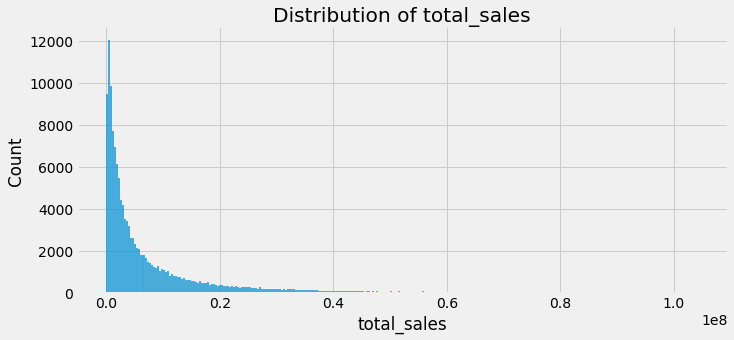

In [8]:
vis_dist(df3, 'total_sales', lim=False)

STATUS: Value counts of "binned"...


,count,percentage (%)
binned,,
"(0, 10000000]",103682,74.119985
"(10000000, 20000000]",17729,12.674073
"(20000000, 30000000]",7541,5.390895
"(30000000, 40000000]",3999,2.858797
"(40000000, 50000000]",2341,1.673529
"(50000000, 60000000]",1602,1.145235
"(60000000, 70000000]",1089,0.778502
"(70000000, 80000000]",804,0.574762
"(80000000, 90000000]",626,0.447514


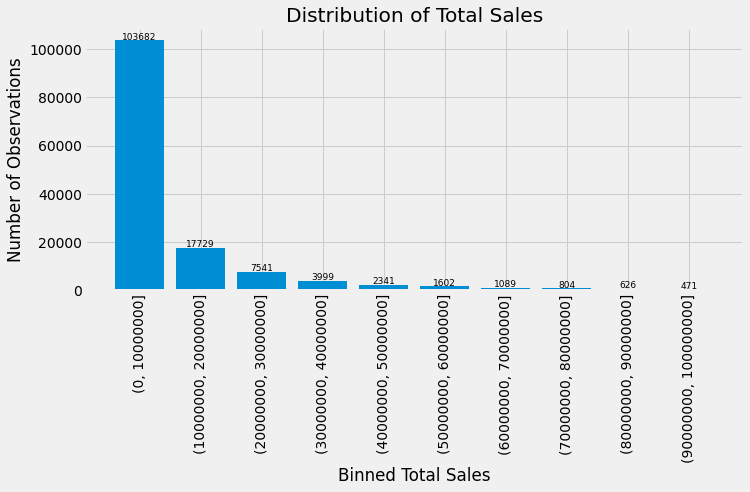

In [9]:
df_uni = df3.copy()
bins = np.arange(0, 104248951, 10000000)
df_uni['binned'] = pd.cut(df3['total_sales'], bins)
v_count = vc(df_uni, 'binned', r=True)
v_count = v_count.reset_index()
v_count['binned'] = v_count['binned'].astype("str")
x_value =v_count['binned'].values
y_value =v_count['count'].values
plt.bar(x_value, y_value)
plt.ylabel('Number of Observations')
plt.xlabel('Binned Total Sales')
plt.title(f'Distribution of Total Sales')
plt.xticks(rotation=90)
for x,y in zip(x_value,y_value):
    label = "{:.1%}".format(y)
    plt.annotate(int(y), # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,1), # distance from text to points (x,y)
                 ha='center' , fontsize=9) # horizontal alignment can be left, right or center
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()

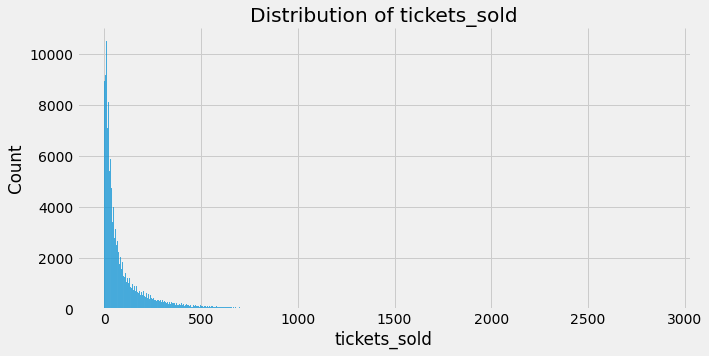

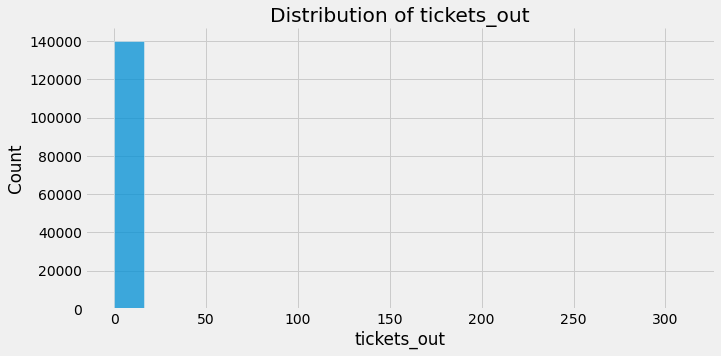

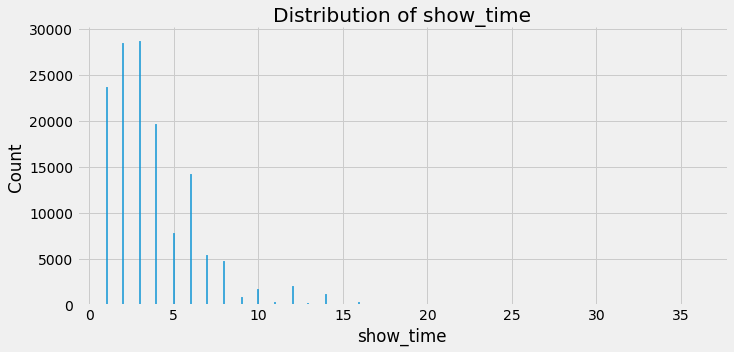

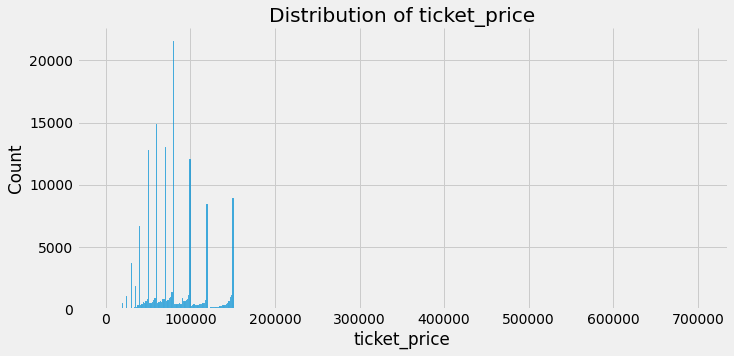

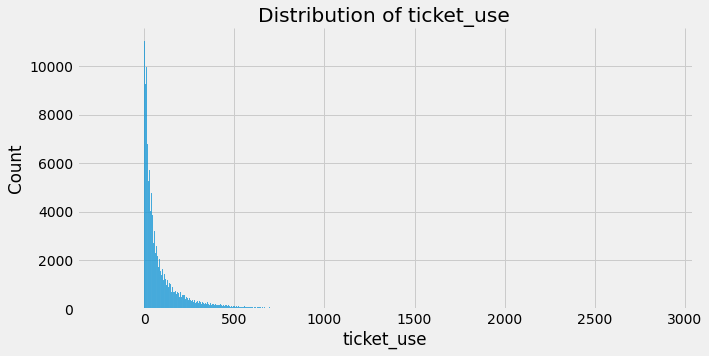

In [10]:
columns = ['tickets_sold', 'tickets_out','show_time','ticket_price','ticket_use']
for col in columns:
    vis_dist(df3, col, lim=False)

# Descriptive Time Series <a class="anchor" id="0.4"></a>

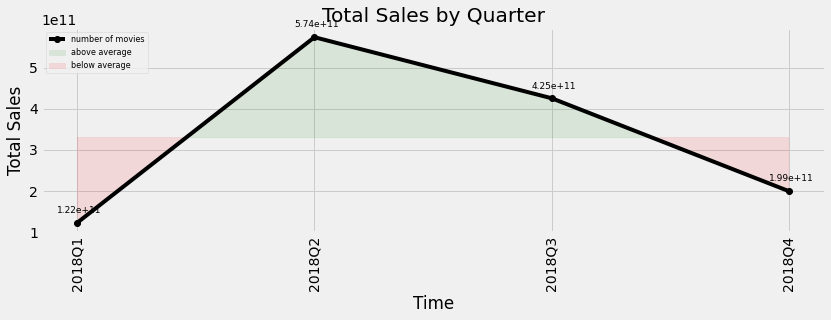

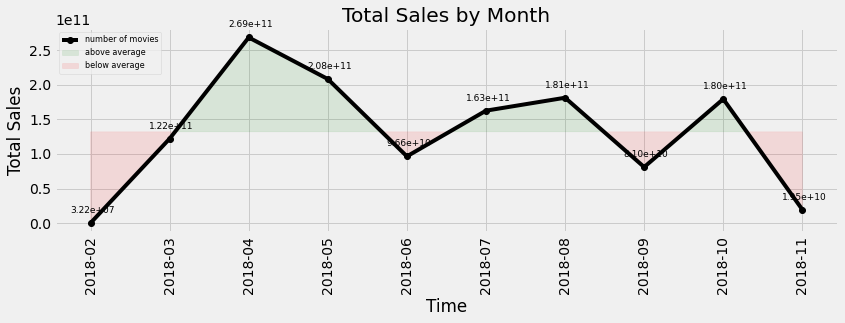

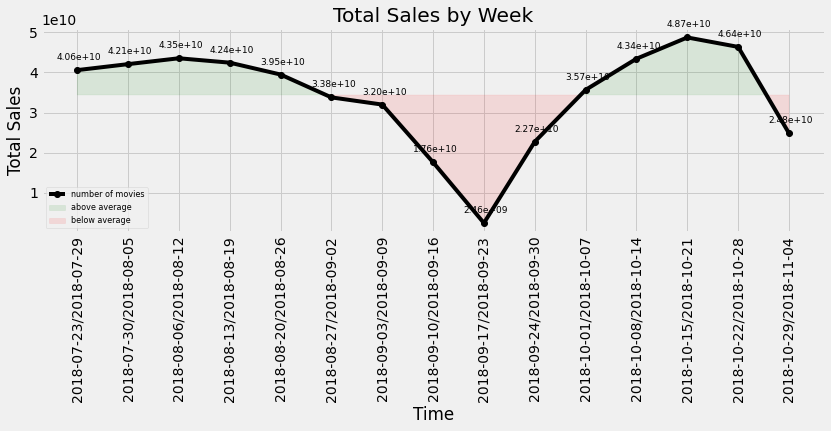

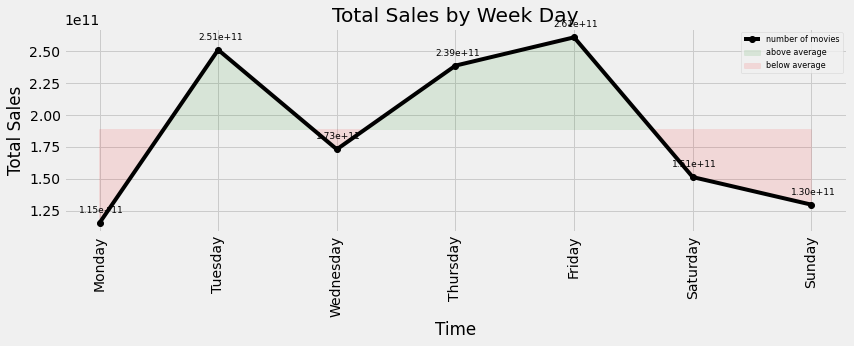

In [11]:
def aggregate_period(df, period, want_mean, column): 
    per = df.date.dt.to_period(period)
    if want_mean == False:
        g = df.groupby(per).agg({'total_sales': ['sum']})
        g.columns = ['metric']
    else:
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.date=g.date.astype(str)
#     g['metric'] = g['metric'].apply(lambda x: "{:e}".format(x))
    return g

def aggregate_period_weekday(df, want_mean, column): 
    per = df['date'].dt.day_name()
    if want_mean == False:
        g = df.groupby(per).agg({'total_sales': ['sum']})
        g.columns = ['metric']
    else:
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.date=g.date.astype(str)
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    g = g.set_index('date').reindex(cats).reset_index()
    return g


def visual(df, title,n,l):
    date = df['date'][-n:] ; count_period =df['metric'][-n:]

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 3.5)
    for x,y in zip(date,count_period):
        label = "{:.2e}".format(y)
        plt.annotate((label), # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center' , fontsize=9) # horizontal alignment can be left, right or center

    overall_mean180 = count_period.mean()
    plt.fill_between(date, count_period,overall_mean180,where=(count_period>overall_mean180),alpha=0.10, interpolate=True, color='Green')
    plt.fill_between(date, count_period,overall_mean180,where=(count_period<=overall_mean180),alpha=0.10, interpolate=True, color='Red')

    plt.legend(['number of movies', 'above average', 'below average'],loc=l, prop={'size': 8})
    plt.xticks(rotation=90)
    return plt.show()

q = aggregate_period(df3, 'q', False, 'na')
m = aggregate_period(df3, 'm', False, 'na')
w = aggregate_period(df3, 'w', False, 'na')
W = aggregate_period_weekday(df3, False, 'na')
visual(q ,"Total Sales by Quarter",25,2)
visual(m ,"Total Sales by Month",25,2)
visual(w ,"Total Sales by Week",15,3)
visual(W ,"Total Sales by Week Day",15,1)

In [12]:
# Aggregate by Day
shape(df3,'df3')
df = aggregate_period(df3, 'd', False, 'na')
shape(df,'df')
df.set_index('date',inplace=True)
df.rename(columns = {'metric':'total_sales'}, inplace=True)
df.tail(10)

STATUS: Dimension of "df3" = (140064, 10)
STATUS: Dimension of "df" = (234, 2)


,total_sales
date,
2018-10-26,10420109998
2018-10-27,4599489998
2018-10-28,3232349000
2018-10-29,859461000
2018-10-30,2070000
2018-10-31,4523308000
2018-11-01,7733829998
2018-11-02,7975330000
2018-11-03,3065780000


# Plot a Time Series <a class="anchor" id="0.5"></a>

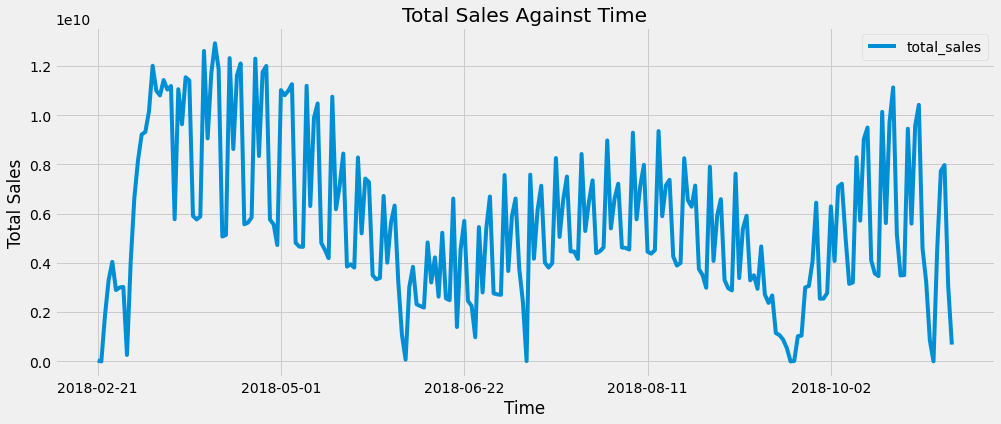

In [13]:
df.plot(figsize=(15, 6))
plt.title(f'Total Sales Against Time')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.show()

# Check Original Stationarity <a class="anchor" id="0.6"></a>

In [14]:
def check_stationarity(df, target):
    timeseries = df[target]
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))
check_stationarity(df , 'total_sales')

The test statistic: -2.252906
p-value: 0.187607
Critical Values:
1%: -3.461
5%: -2.875
10%: -2.574


# Differencing <a class="anchor" id="0.7"></a>

In [15]:
def differencing(df, date, value, order=1):
    d = df
    
    # set date format and as index
    d[date] = pd.to_datetime(d[date],errors='coerce')
    d=d.set_index(date)
    
    print(f"order = {order}")
    if order ==1:
        # calculate xt -1
        d['xt_minus_1'] = d[value].shift(periods=1)

        # calculate first_order_RD
        d['target_order_RD'] = d[value] - d['xt_minus_1']
    
    elif order ==2:
        d['xt_minus_1'] = d[value].shift(periods=1)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        
        # calculate second_order_RD
        d['target_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        
    elif order ==3:
        d['xt_minus_1'] = d[value].shift(periods=1)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        d['target_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        
    elif order ==4:
        d['xt_minus_1'] = d[value].shift(periods=1)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        d['third_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        d['third_order_RD_minus_1'] = d['third_order_RD'].shift(periods=1)
        d['target_order_RD'] = d['third_order_RD'] - d['third_order_RD_minus_1']
    
    elif order ==5:
        d['xt_minus_1'] = d[value].shift(periods=1)
        d['first_order_RD'] = d[value] - d['xt_minus_1']
        d['first_order_RD_minus_1'] = d['first_order_RD'].shift(periods=1)
        d['second_order_RD'] = d['first_order_RD'] - d['first_order_RD_minus_1']
        d['second_order_RD_minus_1'] = d['second_order_RD'].shift(periods=1)
        d['third_order_RD'] = d['second_order_RD'] - d['second_order_RD_minus_1']
        d['third_order_RD_minus_1'] = d['third_order_RD'].shift(periods=1)
        d['forth_order_RD'] = d['third_order_RD'] - d['third_order_RD_minus_1']
        d['forth_order_RD_minus_1'] = d['forth_order_RD'].shift(periods=1)
        d['target_order_RD'] = d['forth_order_RD'] - d['forth_order_RD_minus_1']
    
    else:
        raise Exception("Order is <=5 ")
    # plot target order RD
    d[['target_order_RD']].plot(figsize=(15, 6))
    plt.title(f'Total Sales After Differencing with Order {order} Against Time')
    plt.xlabel('Time')
    plt.ylabel("Total Sales After Differencing")
    plt.show()

    return d

In [16]:
df['total_sales_log'] = np.log(df.total_sales)
df.head()

,total_sales,total_sales_log
date,,
2018-02-21,32030000,17.282184
2018-02-23,180000,12.100712
2018-03-14,1870938994,21.349706
2018-03-15,3309334994,21.920013
2018-03-16,4043241998,22.120313


order = 1


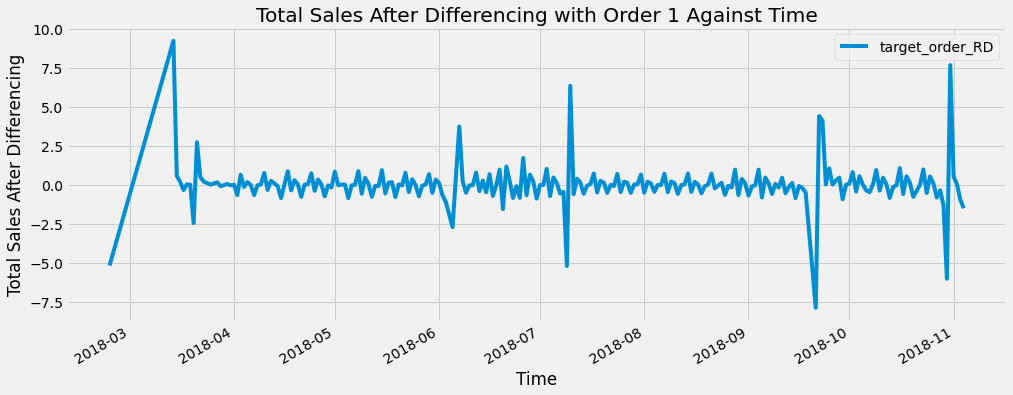

,total_sales,total_sales_log,xt_minus_1,target_order_RD
date,,,,
2018-02-21,32030000,17.282184,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471
2018-03-14,1870938994,21.349706,12.100712,9.248994
2018-03-15,3309334994,21.920013,21.349706,0.570307
2018-03-16,4043241998,22.120313,21.920013,0.200300
...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450
2018-11-01,7733829998,22.768870,22.232509,0.536361
2018-11-02,7975330000,22.799619,22.768870,0.030749


order = 2


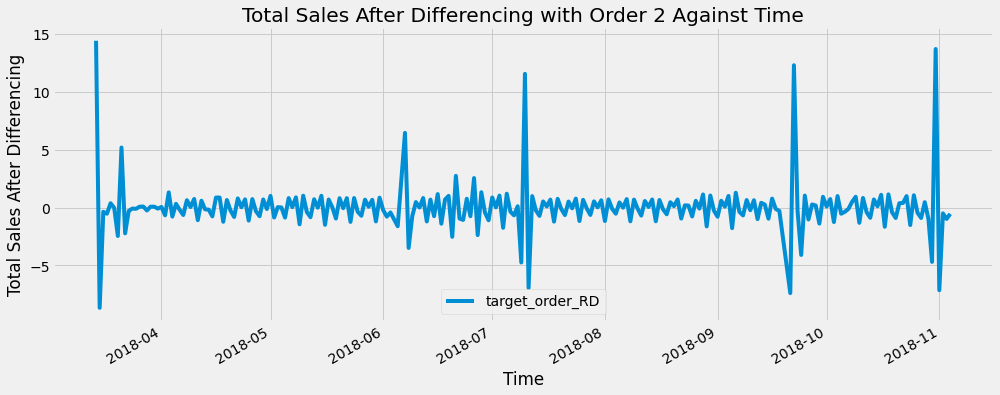

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,target_order_RD
date,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007
...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612


order = 3


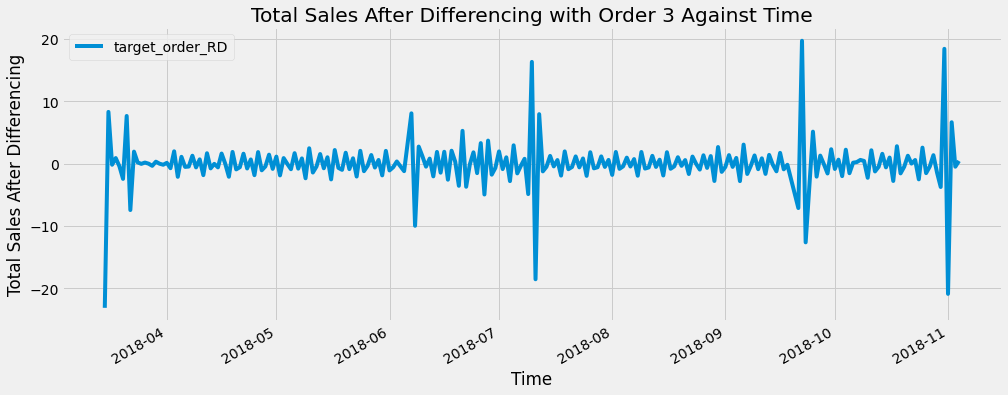

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,target_order_RD
date,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680
...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478


order = 4


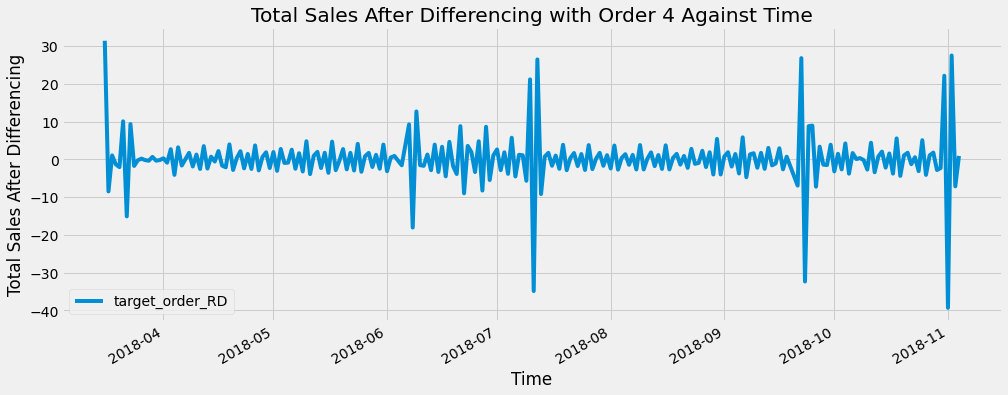

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,third_order_RD,third_order_RD_minus_1,target_order_RD
date,,,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153,NaN,NaN
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680,-23.109153,31.417833
...,...,...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305,-3.732175,22.154480
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297,18.422305,-39.293602
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478,-20.871297,27.518775


order = 5


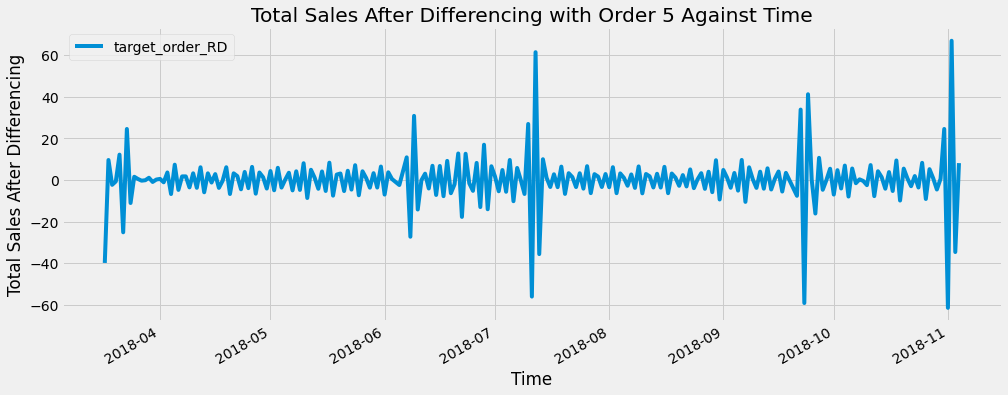

,total_sales,total_sales_log,xt_minus_1,first_order_RD,first_order_RD_minus_1,second_order_RD,second_order_RD_minus_1,third_order_RD,third_order_RD_minus_1,forth_order_RD,forth_order_RD_minus_1,target_order_RD
date,,,,,,,,,,,,
2018-02-21,32030000,17.282184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-23,180000,12.100712,17.282184,-5.181471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-14,1870938994,21.349706,12.100712,9.248994,-5.181471,14.430466,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-15,3309334994,21.920013,21.349706,0.570307,9.248994,-8.678687,14.430466,-23.109153,NaN,NaN,NaN,NaN
2018-03-16,4043241998,22.120313,21.920013,0.200300,0.570307,-0.370007,-8.678687,8.308680,-23.109153,31.417833,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31,4523308000,22.232509,14.543059,7.689450,-6.028757,13.718207,-4.704098,18.422305,-3.732175,22.154480,-2.295197,24.449677
2018-11-01,7733829998,22.768870,22.232509,0.536361,7.689450,-7.153090,13.718207,-20.871297,18.422305,-39.293602,22.154480,-61.448082
2018-11-02,7975330000,22.799619,22.768870,0.030749,0.536361,-0.505612,-7.153090,6.647478,-20.871297,27.518775,-39.293602,66.812376


check stationarity of order 1
The test statistic: -11.317884
p-value: 0.000000
Critical Values:
1%: -3.459
5%: -2.874
10%: -2.574


In [17]:
df_temp = df.reset_index()
df2_T = differencing(df_temp, 'date', 'total_sales_log', order=1) ; display(df2_T)
TEMP = differencing(df_temp, 'date', 'total_sales_log', order=2) ; display(TEMP)
TEMP = differencing(df_temp, 'date', 'total_sales_log', order=3); display(TEMP)
TEMP = differencing(df_temp, 'date', 'total_sales_log', order=4); display(TEMP)
TEMP = differencing(df_temp, 'date', 'total_sales_log', order=5); display(TEMP)

df2 = df2_T.dropna()
print("check stationarity of order 1")
check_stationarity(df2, 'target_order_RD')

# Autocorrelation and Partial Autocorrelation <a class="anchor" id="0.8"></a>

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


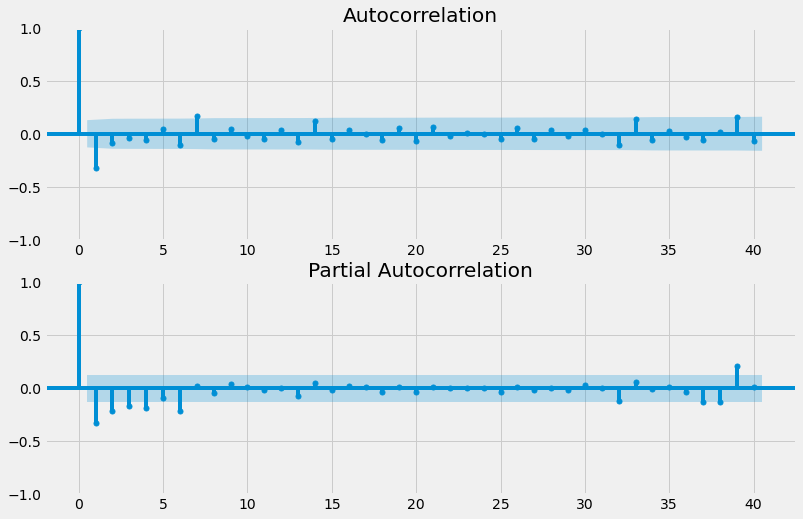

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df2.target_order_RD,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df2.target_order_RD,lags=40,ax=ax2)

In [19]:
def simple_moving_average(arr, window_size, weights=None):
    i = 0
    len_array = len(arr)+1
    answer = [None] * len_array ; computation = [None] * len_array 
    row = window_size
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array t o
    #consider every window of size 3
    while i < len(arr) - window_size + 1:

        # Calculate the average of current window
        if weights ==None:
            array_values = arr[i:i+window_size]
            window_average = round(np.sum(array_values) / window_size, 3)
#             print(f"window_average_of_{window_size} = sum({array_values}) / ({window_size})  =  {window_average}") 
            answer[row] = window_average
            computation[row] = (f" sum({array_values}) / ({window_size})  =  {window_average}")
            row+=1
        else:
            array_values = arr[i:i+window_size]
            array_values_multiplied = [a * b for a, b in zip(array_values, weights)]
            array_values_multiplied = [round(num, 4) for num in array_values_multiplied]
            window_average = round(np.sum(array_values_multiplied), 4)
#             print(f"window_average_of_{window_size} = sum({array_values_multiplied}) =  {window_average}") 
            answer[row] = window_average
            computation[row] = (f"sum({array_values_multiplied}) =  {window_average}") 
            row+=1
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        # Shift window to right by one position
        i += 1
    arr.append(None)
    d = {'Actual': arr, f'Forecasted, w={window_size}':answer, 'Computation':computation}
    df_result = pd.DataFrame(d)
    
    print(f"Forecasted result: {answer[-1]}")
    
    df_metric =  df_result.dropna()
    y_actual = df_metric['Actual'].values.tolist()
    y_predicted  = df_metric[f'Forecasted, w={window_size}'].values.tolist()
    
    return df_result

In [20]:
index = df.index.tolist()
index.append('2018-11-05')

arr  = df[['total_sales']].values.flatten().tolist()
window_size = 2
result_ma = simple_moving_average(arr, window_size, weights=None)
result_ma.index = index
result_ma = result_ma.dropna()
result_ma

Forecasted result: 1874382500.0


,Actual,"Forecasted, w=2",Computation
2018-03-14,1.870939e+09,1.610500e+07,"sum([32030000, 180000]) / (2) = 16105000.0"
2018-03-15,3.309335e+09,9.355595e+08,"sum([180000, 1870938994]) / (2) = 935559497.0"
2018-03-16,4.043242e+09,2.590137e+09,"sum([1870938994, 3309334994]) / (2) = 25901..."
2018-03-17,2.895673e+09,3.676288e+09,"sum([3309334994, 4043241998]) / (2) = 36762..."
2018-03-18,3.002792e+09,3.469457e+09,"sum([4043241998, 2895672996]) / (2) = 34694..."
...,...,...,...
2018-10-31,4.523308e+09,4.307655e+08,"sum([859461000, 2070000]) / (2) = 430765500.0"
2018-11-01,7.733830e+09,2.262689e+09,"sum([2070000, 4523308000]) / (2) = 22626890..."
2018-11-02,7.975330e+09,6.128569e+09,"sum([4523308000, 7733829998]) / (2) = 61285..."
2018-11-03,3.065780e+09,7.854580e+09,"sum([7733829998, 7975330000]) / (2) = 78545..."


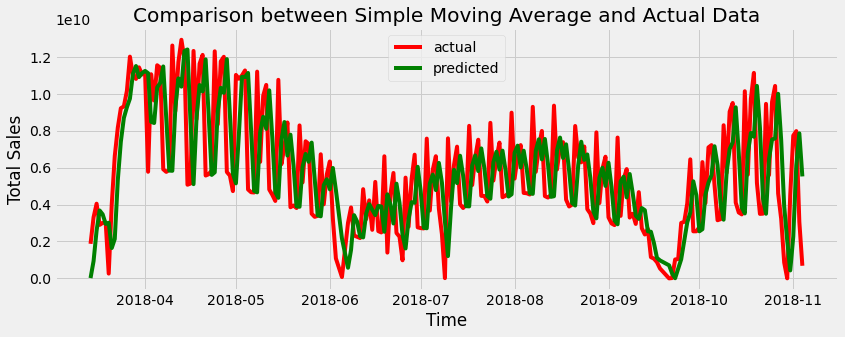

In [21]:
temp = result_ma.reset_index()
temp['index'] = pd.to_datetime(temp["index"],errors='coerce')
result_ma = temp.set_index('index')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between Simple Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")


plt.plot(result_ma.Actual,label = 'actual', color='r' )
plt.plot(result_ma['Forecasted, w=2'],label = 'predicted', color='g' )
plt.legend()

In [22]:
method_list =[] ; granular_method_list=[]; rmse_list =[] ; mse_list =[] ; mae_list =[] ; r2_list =[] ; 
d = {
    'Method': method_list,
    'Granular Method':granular_method_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2': r2_list
}

def get_metric(df, results, method, granular_method):
    # compute metrics
    mse = mean_squared_error(actual, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predict)
    r2 = r2_score(actual, predict)

    # append list
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


    result = pd.DataFrame(d)
    return result

actual = result_ma['Actual'].tail(30) 
predict = result_ma['Forecasted, w=2'].tail(30)
method = 'Timeseries'
granular_method = 'Simple Moving Average'
get_metric(actual, predict, method, granular_method)

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578


In [23]:
index = df.index.tolist()
index.append('2018-11-05')

arr  = df[['total_sales']].values.flatten().tolist()
window_size = 2
weights = [0.2,0.3,0.5]
result_ma_weighted = simple_moving_average(arr, window_size, weights=weights)
result_ma_weighted.index = index
result_ma_weighted = result_ma_weighted.dropna()
result_ma_weighted

Forecasted result: 818051500.0


,Actual,"Forecasted, w=2",Computation
2018-03-14,1.870939e+09,6.460000e+06,"sum([6406000.0, 54000.0]) = 6460000.0"
2018-03-15,3.309335e+09,5.613177e+08,"sum([36000.0, 561281698.2]) = 561317698.2"
2018-03-16,4.043242e+09,1.366988e+09,"sum([374187798.8, 992800498.2]) = 1366988297.0"
2018-03-17,2.895673e+09,1.874840e+09,"sum([661866998.8, 1212972599.4]) = 1874839598.2"
2018-03-18,3.002792e+09,1.677350e+09,"sum([808648399.6, 868701898.8]) = 1677350298.4"
...,...,...,...
2018-10-31,4.523308e+09,1.725132e+08,"sum([171892200.0, 621000.0]) = 172513200.0"
2018-11-01,7.733830e+09,1.357406e+09,"sum([414000.0, 1356992400.0]) = 1357406400.0"
2018-11-02,7.975330e+09,3.224811e+09,"sum([904661600.0, 2320148999.4]) = 3224810599.4"
2018-11-03,3.065780e+09,3.939365e+09,"sum([1546765999.6, 2392599000.0]) = 3939364999.6"


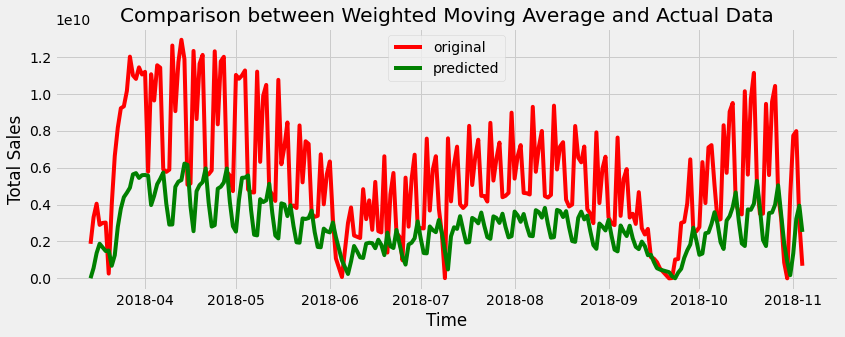

In [24]:
temp = result_ma_weighted.reset_index()
temp['index'] = pd.to_datetime(temp["index"],errors='coerce')
result_ma_weighted = temp.set_index('index')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between Weighted Moving Average and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(result_ma_weighted.Actual,label = 'original', color='r' )
plt.plot(result_ma_weighted['Forecasted, w=2'],label = 'predicted', color='g' )
plt.legend()

In [25]:
actual = result_ma_weighted['Actual'].tail(30) 
predict = result_ma_weighted['Forecasted, w=2'].tail(30)
method = 'Timeseries'
granular_method = 'Weighted Moving Average'
get_metric(actual, predict, method, granular_method)

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210


# Find Best ARIMA <a class="anchor" id="0.9"></a>

In [26]:
auto_arima_fit = pm.auto_arima(df.total_sales, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                             seasonal=False, trace=True, error_action='ignore', suppress_warnings=True,
                             stepwise=True)

/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10750.810, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10815.783, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10788.369, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10756.223, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10813.785, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10752.217, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10739.277, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10749.278, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10751.820, Time=0.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10744.388, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10757.360, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10732.491, Time=0.86 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10712.348, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0] i

In [27]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = ARIMA(df.total_sales, order=(3,1,2))
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                  234
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -5349.041
Date:                Wed, 10 Aug 2022   AIC                          10710.082
Time:                        13:19:01   BIC                          10730.788
Sample:                             0   HQIC                         10718.431
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8801      0.053     16.629      0.000       0.776       0.984
ar.L2         -0.3482      0.070     -4.950      0.000      -0.486      -0.210
ar.L3         -0.3198      0.061     -5.201      0.0

# Residual Plot <a class="anchor" id="0.11"></a>

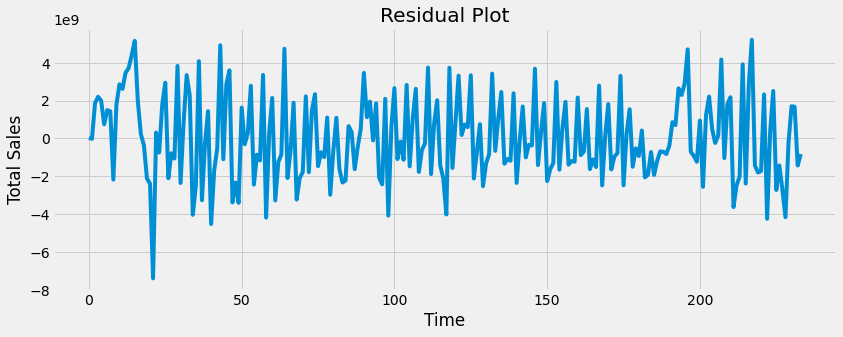

In [28]:
residuals = pd.DataFrame(results.resid)

temp = residuals.reset_index()
temp['date'] = pd.to_datetime(temp["date"],errors='coerce')
residuals = temp.set_index('date')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Residual Plot')
plt.xlabel('Time')
plt.ylabel("Total Sales")
plt.plot(residuals.values )


Text(0, 0.5, 'Total Sales')

<Figure size 432x288 with 0 Axes>

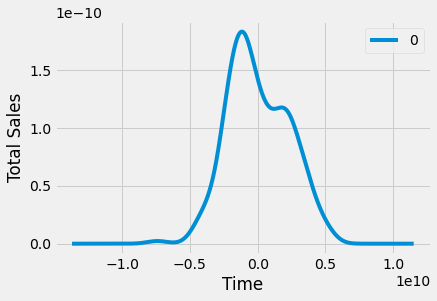

In [29]:
fig = matplotlib.pyplot.gcf()
ax = residuals.plot(kind='kde')
ax.set_xlabel('Time')
ax.set_ylabel("Total Sales")

In [30]:
residuals.describe()

,0
count,2.340000e+02
mean,3.771118e+07
std,2.212655e+09
min,-7.389388e+09
25%,-1.543907e+09
50%,-3.487167e+08
75%,1.845270e+09
max,5.209873e+09


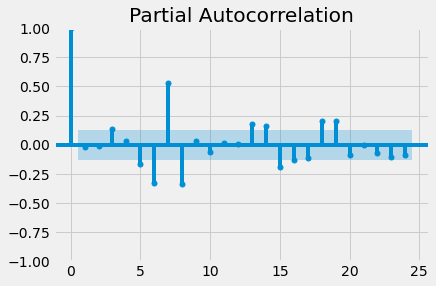

In [31]:
plot_pacf(residuals)
print()

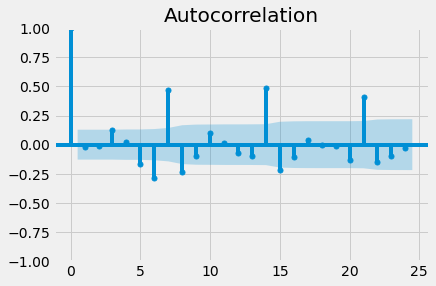

In [32]:
plot_acf(residuals)
print()

# Prediction Plot <a class="anchor" id="0.12"></a>

In [33]:
def coerce_time(df, attribute):
    temp = df.reset_index()
    temp[attribute] = pd.to_datetime(temp[attribute],errors='coerce')
    df = temp.set_index(attribute)
    return df

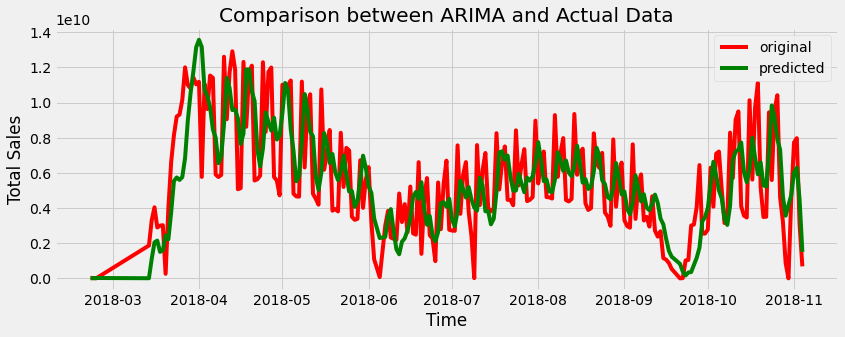

In [34]:
index_list = df[:234].index.tolist()
prediction = results.predict(0,233)
prediction = prediction.set_axis(index_list)
prediction = prediction.to_frame()
prediction = coerce_time(prediction, 'index')
df = coerce_time(df, 'date')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between ARIMA and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df.total_sales[:234],label = 'original', color='r' )
plt.plot(prediction,label = 'predicted', color='g' )

plt.legend()

In [35]:
def get_forecast_values(df, N =30):
    last_date = df.reset_index().at[len(df)-1,'date']
    print(f"last date: {last_date}")
    for_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)
    print(f"start forcast date: {for_date}")

    forecast = results.forecast(steps=N)
    index = pd.date_range(start=for_date, periods=N)

    df_forecast = pd.DataFrame({'forecast':forecast.values},index=index)
    return df_forecast

df_forecast = get_forecast_values(df, N =30)

df = df[['total_sales']]

aa = df.reset_index()
aa['date'] = pd.to_datetime(aa['date'],errors='coerce')
print(aa.info())
aa.set_index('date', inplace=True)
print(aa.info())

xx = df_forecast.reset_index()
print(xx.info())
xx.rename(columns = {'index':'date'}, inplace=True)
xx.set_index('date', inplace=True)
print(xx.info())

last date: 2018-11-04 00:00:00
start forcast date: 2018-11-05 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         234 non-null    datetime64[ns]
 1   total_sales  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2018-02-21 to 2018-11-04
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_sales  234 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     30 non-null     datetime64[ns]
 1   forecast  30 non-null     float64   

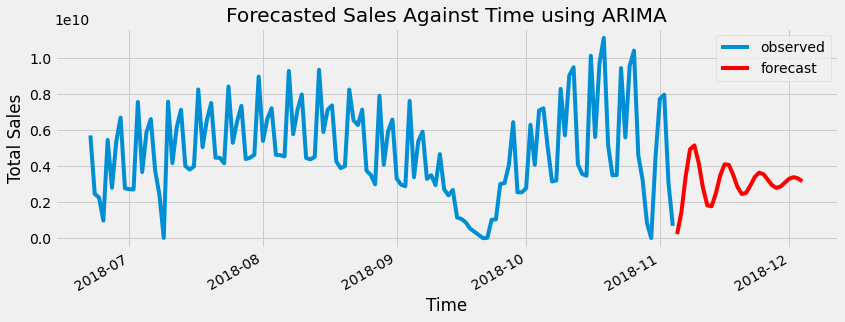

In [36]:
df_forecast =xx
df = aa

def show_forecast_plot(df, df_forecast, method):
    ci = df_forecast.values
    ax = df[100:].total_sales.plot(label='observed', figsize=(20, 15))
    df_forecast.plot(ax=ax,label='Forecast',color='r')
    ax.fill_between(df_forecast.index,
                    ci[:,-1],
                    ci[:,0], color='b', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Total Sales')
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.legend()
    
    plt.title(f'Forecasted Sales Against Time using {method}')
    plt.xlabel('Time')
    plt.ylabel("Total Sales")
    return plt.show()

show_forecast_plot(df, df_forecast,'ARIMA')

In [37]:
def get_metric(df, results, method, granular_method):
    actual = df['total_sales'].tail(30) 
    predict = results.predict().tail(30)

    # compute metrics
    mse = mean_squared_error(actual, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predict)
    r2 = r2_score(actual, predict)

    # append list
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)


    result = pd.DataFrame(d)
    return result

method = 'Timeseries'
granular_method = 'ARIMA'
get_metric(df, results, method, granular_method)

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219


# SARIMAX <a class="anchor" id="0.13"></a>

In [38]:
Sarimax_model = auto_arima(df.total_sales,start_P=1,start_q=1, max_p=3,max_q=3, m=12,seasonal=True,d=None,D=1,
                       trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10445.753, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10359.928, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10444.193, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10395.175, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10354.999, Time=0.82 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=10429.498, Time=0.94 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=10353.304, Time=1.42 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10361.082, Time=0.49 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

In [39]:
model = SARIMAX(df.total_sales,order=(3, 0, 3),
              seasonal_order=(2, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41593D+08    |proj g|=  5.39762D+09


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      5     49      2     0     0   1.804D+09   3.574D+07
  F =   35743115.565984085     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


                                      SARIMAX Results                                      
Dep. Variable:                         total_sales   No. Observations:                  234
Model:             SARIMAX(3, 0, 3)x(2, 1, [], 12)   Log Likelihood         -8363889042.440
Date:                             Wed, 10 Aug 2022   AIC                    16727778102.881
Time:                                     13:21:49   BIC                    16727778132.338
Sample:                                          0   HQIC                   16727778114.807
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1876   1.06e-05   1.12e+05      0.000       1.188       1.188
ar.L2         -1.3112   1.0

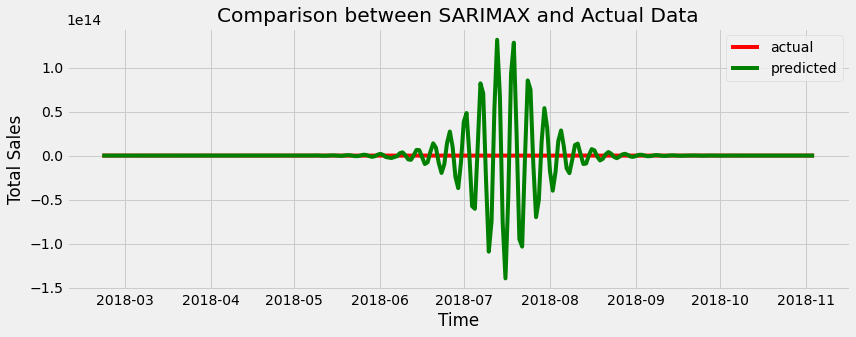

In [40]:
index_list = df[:234].index.tolist()
prediction = results.predict(0,233)
prediction = prediction.set_axis(index_list)
prediction = prediction.to_frame()
prediction = coerce_time(prediction, 'index')
df = coerce_time(df, 'date')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between SARIMAX and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(df.total_sales[:234],label = 'actual', color='r' )
plt.plot(prediction,label = 'predicted', color='g' )
plt.legend()

In [41]:
df_forecast = get_forecast_values(df, N =30)

df = df[['total_sales']]

aa = df.reset_index()
aa['date'] = pd.to_datetime(aa['date'],errors='coerce')
print(aa.info())
aa.set_index('date', inplace=True)
print(aa.info())

xx = df_forecast.reset_index()
print(xx.info())
xx.rename(columns = {'index':'date'}, inplace=True)
xx.set_index('date', inplace=True)
print(xx.info())

last date: 2018-11-04 00:00:00
start forcast date: 2018-11-05 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         234 non-null    datetime64[ns]
 1   total_sales  234 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2018-02-21 to 2018-11-04
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   total_sales  234 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     30 non-null     datetime64[ns]
 1   forecast  30 non-null     float64   

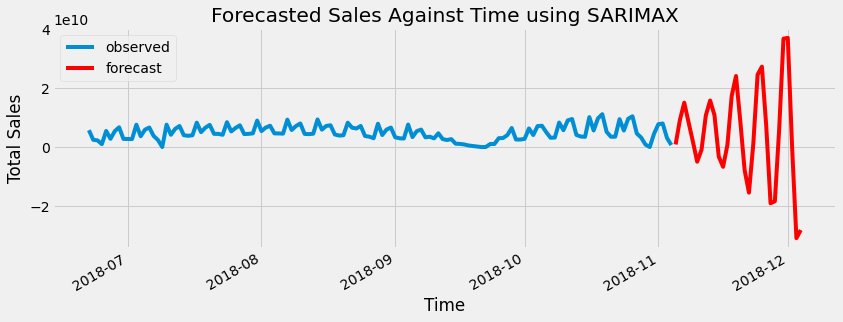

In [42]:
df_forecast = xx
df = aa

show_forecast_plot(df, df_forecast,'SARIMAX')

In [43]:
method = 'Timeseries'
granular_method = 'SARIMAX'
result = get_metric(df, results, method, granular_method)
result

,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219
3,Timeseries,SARIMAX,1.059172e+20,1.029161e+10,7.143514e+09,-9.955959


# Machine Learning <a class="anchor" id="0.14"></a>

In [44]:
def get_data():
    df2 = df.copy()
    df2['shift_1'] =  df2['total_sales'].shift(periods=1)
    df2['shift_2'] =  df2['total_sales'].shift(periods=2)
    df2['shift_3'] =  df2['total_sales'].shift(periods=3)
    df2['shift_4'] =  df2['total_sales'].shift(periods=4)
    df2['shift_5'] =  df2['total_sales'].shift(periods=5)
    df2 = df2.dropna()
    return df2

def get_forcast_date(df):
    forcast_date = df.index[-1]+ pd.DateOffset(days=1)
    return forcast_date

def append_row(df):
    new_row = np.flip(np.append(df.total_sales[-5:].values, np.nan))
    forcast_date = get_forcast_date(df)
    # add new row with specified index name
    df.loc[forcast_date] = new_row
    return df, forcast_date

def train_test_split(df2, n_test):
    x_train = df2.iloc[:-n_test: , 1:]  ; shape(x_train,'x_train')
    y_train = df2.iloc[:-n_test: , :1] ; shape(y_train,'y_train')
    x_test = df2.iloc[-n_test: , 1:] ; shape(x_test,'x_test')
    y_test = df2.iloc[-n_test: , :1] ; shape(y_test,'y_test')
    
    return x_train, y_train, x_test, y_test

def model_train(x_train, y_train, model, model_value):
    if model == 'XGB':
        print("Using XGB model")
        model = model_value #XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=0)
    else:
        print("Using RFR model")
        model = model_value #RandomForestRegressor(random_state=0)
    # fit model
    model = model.fit(x_train, y_train)
    
    # TEST PREDICT
    x_train_pred = model.predict(x_train)
    print("Model Fit Already")
    return model, x_train_pred

def model_test_predict(model_fit, x_test):
    yhat = model_fit.predict(x_test.values)
    return yhat

def get_metrics_ml(model_fit, x_test, y_test, model):
    yhat = model_test_predict(model_fit, x_test)
    mse = mean_squared_error(y_test, yhat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, yhat)
    r2 = r2_score(y_test, yhat)
    
    ###
    method = 'Machine Learning'
#     if model == 'XGB':
#         granular_method = 'XGB'
#     else:
#         granular_method = 'Random Forest'
    granular_method = model

    # append list
    method_list.append(method)
    granular_method_list.append(granular_method)
    rmse_list.append(rmse)
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    result = pd.DataFrame(d)
    return result
    
def model_forecast(model_fit, df):
    new_row = np.flip(df.total_sales[-5:].values)
    yhat = model_fit.predict([new_row.tolist()])
    df, forcast_date = append_row(df)
    df.at[forcast_date, 'total_sales'] = yhat
    return df

def model_forecast_n(n, model_fit, df):
    for nx in range(n):
        df = model_forecast(model_fit, df)
    return df

In [45]:
# to get metric for machine learning model
df2 = get_data()
forcast_date = get_forcast_date(df2)
print(forcast_date)

x_train, y_train, x_test, y_test = train_test_split(df2, 30)

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=100))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=100)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=200))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=200)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
result = get_metrics_ml(model_fit, x_test, y_test, 'RFR(n_estimators=300)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=100)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=200)')

model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=0))
result = get_metrics_ml(model_fit, x_test, y_test, 'XGB(n_estimators=300)')

# model_fit, x_train_pred_XGB = model_train(x_train, y_train, 'XGB')
# result = get_metrics_ml(model_fit, x_test, y_test, 'XGB')
result

2018-11-05 00:00:00
STATUS: Dimension of "x_train" = (199, 5)
STATUS: Dimension of "y_train" = (199, 1)
STATUS: Dimension of "x_test" = (30, 5)
STATUS: Dimension of "y_test" = (30, 1)
Using RFR model
Model Fit Already
Using RFR model
Model Fit Already
Using RFR model
Model Fit Already
Using XGB model
Model Fit Already
Using XGB model
Model Fit Already
Using XGB model
Model Fit Already


,Method,Granular Method,MSE,RMSE,MAE,R2
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219
3,Timeseries,SARIMAX,1.059172e+20,1.029161e+10,7.143514e+09,-9.955959
4,Machine Learning,RFR(n_estimators=100),7.663778e+18,2.768353e+09,2.388568e+09,0.207267
5,Machine Learning,RFR(n_estimators=200),7.417655e+18,2.723537e+09,2.329582e+09,0.232726
6,Machine Learning,RFR(n_estimators=300),7.409955e+18,2.722123e+09,2.329854e+09,0.233522
7,Machine Learning,XGB(n_estimators=100),8.220709e+18,2.867178e+09,2.273592e+09,0.149659
8,Machine Learning,XGB(n_estimators=200),8.219685e+18,2.866999e+09,2.273558e+09,0.149765
9,Machine Learning,XGB(n_estimators=300),8.219713e+18,2.867004e+09,2.273564e+09,0.149762


In [46]:
# to forecast RFR
df2 = get_data()

forcast_date = get_forcast_date(df2)
print(forcast_date)
x_train, y_train, x_test, y_test = train_test_split(df2, 30)
model_fit, x_train_pred_RFR = model_train(x_train, y_train, 'RFR', RandomForestRegressor(random_state=0, n_estimators=300))
df2 = model_forecast_n(30, model_fit, df2)
df2

2018-11-05 00:00:00
STATUS: Dimension of "x_train" = (199, 5)
STATUS: Dimension of "y_train" = (199, 1)
STATUS: Dimension of "x_test" = (30, 5)
STATUS: Dimension of "y_test" = (30, 1)
Using RFR model
Model Fit Already


,total_sales,shift_1,shift_2,shift_3,shift_4,shift_5
date,,,,,,
2018-03-17,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05,3.203000e+07
2018-03-18,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05
2018-03-19,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09
2018-03-20,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09
2018-03-21,4.008355e+09,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09
...,...,...,...,...,...,...
2018-11-30,5.053567e+09,5.076425e+09,5.228688e+09,5.385911e+09,5.511779e+09,5.300032e+09
2018-12-01,5.240952e+09,5.053567e+09,5.076425e+09,5.228688e+09,5.385911e+09,5.511779e+09
2018-12-02,5.285959e+09,5.240952e+09,5.053567e+09,5.076425e+09,5.228688e+09,5.385911e+09


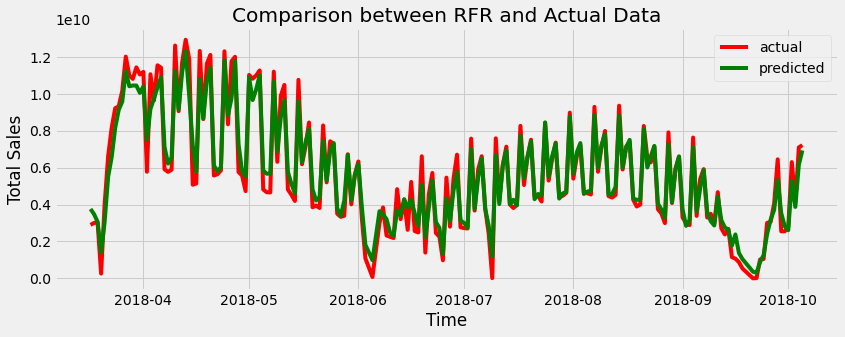

In [47]:
actual = get_data().iloc[:-30: ]
index_list = actual.index.tolist()
prediction = x_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between RFR and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual.total_sales, label = 'actual', color='r' )
plt.plot(prediction, label = 'predicted', color='g' )
plt.legend()

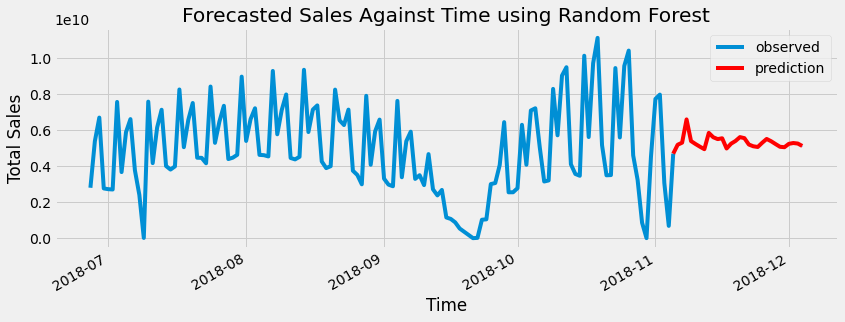

In [48]:
df_actual = df2[['total_sales']].loc[:forcast_date]
df_forecast = df2[['total_sales']].loc[forcast_date:]
df_forecast = df_forecast.rename(columns = {'total_sales':'prediction'})
show_forecast_plot(df_actual, df_forecast,'Random Forest')

# To Forecast using XGB

In [49]:
# to forecast XGB
df2 = get_data()

forcast_date = get_forcast_date(df2)
print(forcast_date)
x_train, y_train, x_test, y_test = train_test_split(df2, 30)
model_fit,x_train_pred_XGB  = model_train(x_train.values, y_train.values, 'XGB', XGBRegressor(objective='reg:squarederror', n_estimators=300, random_state=0))
df2 = model_forecast_n(30, model_fit, df2)
df2

2018-11-05 00:00:00
STATUS: Dimension of "x_train" = (199, 5)
STATUS: Dimension of "y_train" = (199, 1)
STATUS: Dimension of "x_test" = (30, 5)
STATUS: Dimension of "y_test" = (30, 1)
Using XGB model
Model Fit Already


,total_sales,shift_1,shift_2,shift_3,shift_4,shift_5
date,,,,,,
2018-03-17,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05,3.203000e+07
2018-03-18,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09,1.800000e+05
2018-03-19,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09,1.870939e+09
2018-03-20,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09,3.309335e+09
2018-03-21,4.008355e+09,2.596050e+08,3.023950e+09,3.002792e+09,2.895673e+09,4.043242e+09
...,...,...,...,...,...,...
2018-11-30,6.718435e+09,7.201734e+09,6.652151e+09,4.811353e+09,6.469317e+09,7.175907e+09
2018-12-01,7.937286e+09,6.718435e+09,7.201734e+09,6.652151e+09,4.811353e+09,6.469317e+09
2018-12-02,4.982003e+09,7.937286e+09,6.718435e+09,7.201734e+09,6.652151e+09,4.811353e+09


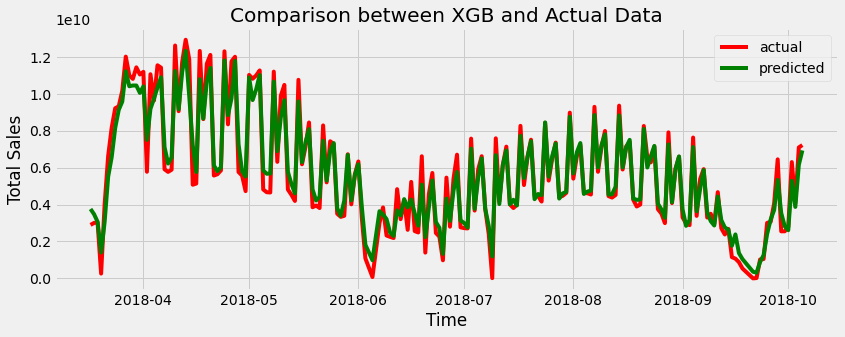

In [50]:
actual = get_data().iloc[:-30: ]
index_list = actual.index.tolist()
prediction = x_train_pred_RFR
prediction = pd.DataFrame({'prediction': prediction}, index=index_list)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 4.5)
plt.title(f'Comparison between XGB and Actual Data')
plt.xlabel('Time')
plt.ylabel("Total Sales")

plt.plot(actual.total_sales, label = 'actual', color='r' )
plt.plot(prediction, label = 'predicted', color='g' )
plt.legend()

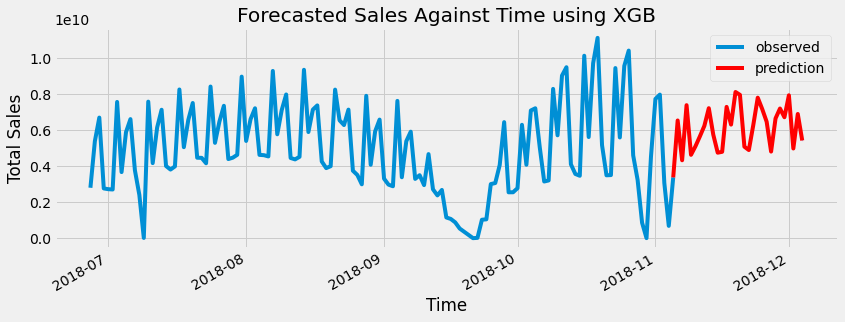

In [51]:
df = df2[['total_sales']].loc[:forcast_date]
df_forecast = df2[['total_sales']].loc[forcast_date:]
df_forecast = df_forecast.rename(columns = {'total_sales':'prediction'})
show_forecast_plot(df, df_forecast,'XGB')

In [52]:
result['AIC'] = 199 * np.log(result['MSE']) + 2 * 100
result['BIC'] = 199 * np.log(result['MSE']) + 100 * np.log(199)

# RFR 200
result.at[5,'AIC'] = 199 * np.log(result.at[5,'MSE']) + 2 * 200
result.at[5,'BIC'] = 199 * np.log(result.at[5,'MSE']) + 200 * np.log(199)

# RFR 300
result.at[6,'AIC'] = 199 * np.log(result.at[6,'MSE']) + 2 * 300
result.at[6,'BIC'] = 199 * np.log(result.at[6,'MSE']) + 300 * np.log(199)

# XGB 200
result.at[8,'AIC'] = 199 * np.log(result.at[8,'MSE']) + 2 * 200
result.at[8,'BIC'] = 199 * np.log(result.at[8,'MSE']) + 200 * np.log(199)

# XGB 300
result.at[9,'AIC'] = 199 * np.log(result.at[9,'MSE']) + 2 * 300
result.at[9,'BIC'] = 199 * np.log(result.at[9,'MSE']) + 300 * np.log(199)

# ARIMA
result.at[2,'AIC'] =10710.082; result.at[2,'BIC'] =10730.788 ; 

# sarimax
result.at[3,'AIC'] =9014.453; result.at[3,'BIC'] =9043.910 ; 

# MA
result.at[0,'AIC'] =234 * np.log(result.at[0,'MSE']) + 2 * 2; 
result.at[0,'BIC'] =234 * np.log(result.at[0,'MSE']) + 2 * np.log(234) ; 

# Weighted
result.at[1,'AIC'] =234 * np.log(result.at[1,'MSE']) + 2 * 2; 
result.at[1,'BIC'] =234 * np.log(result.at[1,'MSE']) + 2 * np.log(234) ; 

result

,Method,Granular Method,MSE,RMSE,MAE,R2,AIC,BIC
0,Timeseries,Simple Moving Average,1.341446e+19,3.662576e+09,3.180345e+09,-0.387578,10310.030431,10316.941073
1,Timeseries,Weighted Moving Average,1.712324e+19,4.138024e+09,3.140596e+09,-0.771210,10367.150625,10374.061267
2,Timeseries,ARIMA,6.233445e+18,2.496687e+09,2.128069e+09,0.355219,10710.082000,10730.788000
3,Timeseries,SARIMAX,1.059172e+20,1.029161e+10,7.143514e+09,-9.955959,9014.453000,9043.910000
4,Machine Learning,RFR(n_estimators=100),7.663778e+18,2.768353e+09,2.388568e+09,0.207267,8853.124321,9182.454803
5,Machine Learning,RFR(n_estimators=200),7.417655e+18,2.723537e+09,2.329582e+09,0.232726,9046.628533,9705.289498
6,Machine Learning,RFR(n_estimators=300),7.409955e+18,2.722123e+09,2.329854e+09,0.233522,9246.421854,10234.413302
7,Machine Learning,XGB(n_estimators=100),8.220709e+18,2.867178e+09,2.273592e+09,0.149659,8867.084443,9196.414926
8,Machine Learning,XGB(n_estimators=200),8.219685e+18,2.866999e+09,2.273558e+09,0.149765,9067.059652,9725.720617
9,Machine Learning,XGB(n_estimators=300),8.219713e+18,2.867004e+09,2.273564e+09,0.149762,9267.060317,10255.051764


# Concluding Remarks <a class="anchor" id="0.15"></a>

With the purpose of model selection, one can notice that the moving average related models in this paper, i.e., MA(2) and Weighted MA(2), have negative R^2. The range of R-squared can take values in the range (−∞, 1]. The R^2 can be negative whenever the fit model fits the data worse than a horizontal line in a nonlinear function. Hence, these models are excluded for the consideration of model selection.

In addition, ARIMA(3, 1, 2) has the lowest MSE, lowest  RMSE, lowest MAE and the highest R^2. This indicates that the ARIMA model is the best model in mapping the underlying ground truth functions of the total sales. However, the ARIMA model does not has the best AIC and BIC metrics. Meaning that although the model has the best performance, but it does not have the best trade-off between model fit and complexity of the model.

Furthermore, the best trade-off between model fit and complexity of the model is RFR with parameter of (n_estimators=100). However, the model can only have an average of R^2, i.e., fourth highest R^2  of all the selected models. R-squared is highlighted in this research since it is thought to be the most informative performance metric over the other metrics, and the standard metric to evaluate scientific domain analyses as suggested by the journal paper prepared by Chicco. Moreover, other scholar has suggested that one can select model with a low AIC and a high R-Squared. 

Therefore, in the final analysis, if an entity would like to have a model that has the highest performance metrics, then one can select the ARIMA(3, 1, 2) as the best model. Conversely, if an entity would like to focus on efficiency of using the training data without overfitting, then one can select the RFR(n_estimators=100) as the best model. Hence, an entity can used the best model according to their related needs to forecast future sales value with the potential benefits of, for example, allocating the right marketing resource, planning for growth and optimising the screening time.
